# Policy Gradient Methods

Policy _based_ methods learn the optimal policy directly, without necessarily estimating a value
function. Policy _gradient_ methods do that performing gradient ascent on the objective function.

### Advantages

 * No need to store action-values.
 * Ability to learn a stochastic policy direcly.
 * Hence, no need to manually tune exploitation vs. exploration.
 * Effective in continuous action spaces (and high-dimensional state spaces).
 * They generally have good convergence properties.

### Disadvantages

 * They might have high-variance.
 * Might converge to a local maximum.
 * Slower than other methods, and might take a long time to train.

In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from typing import Union

import gymnasium as gym

from util.gymnastics import DEVICE, gym_simulation, init_random, plot_scores

## CartPole Environment

Moviepy - Building video /tmp/rl-video-episode-0.mp4.
Moviepy - Writing video /tmp/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /tmp/rl-video-episode-0.mp4
MoviePy - Building file /tmp/rl-video.gif with imageio.


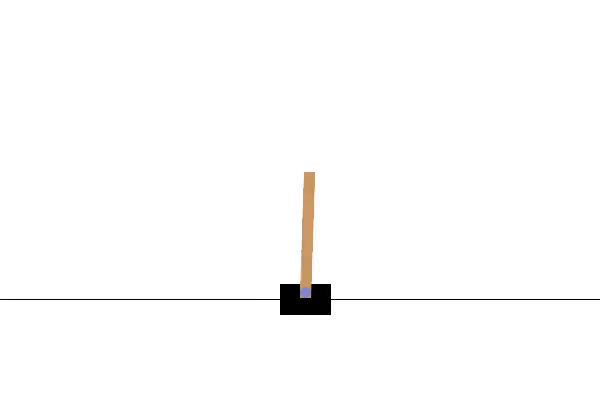

In [2]:
gym_simulation("CartPole-v1")

In [3]:
# Just for convenience, we hardcode the state and action sizes of the CartPole environment.
STATE_SIZE  = 4
ACTION_SIZE = 2

## Optimization Rule

For one trajectory $\tau$ (or episode), the neural networks weight can be updated according to:

$$
\theta_{k+1} = \theta_k - \alpha \sum_{t=0} \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) R(\tau)
$$

We can interpret this as pushing up probabilities for action / states combinations when the return
is high, and the other way around for low returns.

This relationship is also interesting because only the policy function needs to be differentiable:
the reward function might very well be discontinuous and sparse.

For derivation, check the [Hugging Face Deep RL tutorial](https://huggingface.co/learn/deep-rl-course/unit4/pg-theorem).

## REINFORCE

<div style="width: 70%">
  <img src="../assets/04_PG_reinforce.png">
  <br>
  <small>Sutton & Barto 2022</small>
</div>

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, hidden_units=16):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(STATE_SIZE, hidden_units)
        self.fc2 = nn.Linear(hidden_units, ACTION_SIZE)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [5]:
class Agent:
    def __init__(self):
        self.policy = PolicyNetwork()
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-2)

    def sample_action(self, state: np.array):
        state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        probs = self.policy.forward(state).cpu()
        cdist = Categorical(probs)
        action = cdist.sample()
        return action.item(), cdist.log_prob(action)

    def learn(self, log_probs: list[torch.Tensor], returns: Union[np.float64, np.array]):
        returns = torch.tensor(returns, dtype=torch.float64, device=DEVICE)
        policy_loss = -(torch.cat(log_probs) * returns).sum()
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
    
    @torch.no_grad
    def act(self, state):
        """Convenient method for the agent to select an action during simulation."""
        return self.sample_action(state)[0]

In [6]:
def REINFORCE(env, agent, max_episodes=10_000, max_t=1_000, gamma=1.0):
    scores = []
    for i_episode in range(1, max_episodes + 1):
        rewards = []
        log_probs = []
        state, _ = env.reset()

        for _ in range(max_t):
            action, log_prob = agent.sample_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            log_probs.append(log_prob)
            if terminated or truncated:
                break

        discounts = np.power(gamma, np.arange(len(rewards)))
        R = np.sum(discounts * rewards)

        agent.learn(log_probs, R)

        # Track scores and print statistics.
        scores.append(sum(rewards))
        avg_score = np.mean(scores[-100:])
        if i_episode % 100 == 0:
            print(f'Episode {i_episode}\tAverage Score: {avg_score:.2f}')
        if avg_score >= 490.0: # Solved
            print(f'Environment solved at episode {i_episode}\tAverage Score: {avg_score:.2f}')
            break

    return scores

Episode 100	Average Score: 25.34
Episode 200	Average Score: 41.29
Episode 300	Average Score: 53.53
Episode 400	Average Score: 49.31
Episode 500	Average Score: 25.35
Episode 600	Average Score: 54.79
Episode 700	Average Score: 99.60
Episode 800	Average Score: 65.03
Episode 900	Average Score: 66.09
Episode 1000	Average Score: 50.15
Episode 1100	Average Score: 36.99
Episode 1200	Average Score: 59.14
Episode 1300	Average Score: 83.41
Episode 1400	Average Score: 36.24
Episode 1500	Average Score: 45.99
Episode 1600	Average Score: 48.32
Episode 1700	Average Score: 93.74
Episode 1800	Average Score: 71.41
Episode 1900	Average Score: 228.79
Episode 2000	Average Score: 103.48
Episode 2100	Average Score: 141.45
Episode 2200	Average Score: 247.82
Episode 2300	Average Score: 412.89
Environment solved at episode 2397	Average Score: 490.75


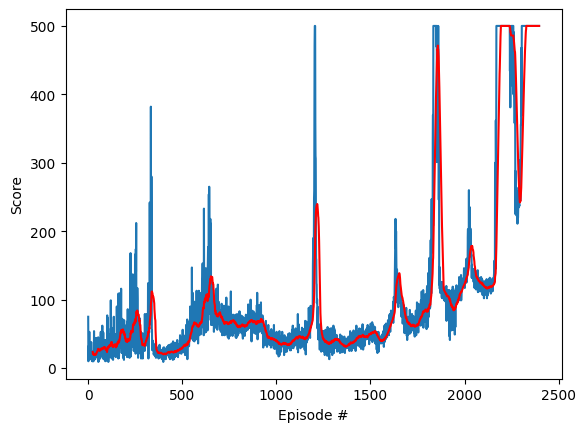

In [7]:
with init_random(gym.make('CartPole-v1')) as env:
    agent = Agent()
    scores = REINFORCE(env, agent)
plot_scores(scores)

Moviepy - Building video /tmp/rl-video-episode-0.mp4.
Moviepy - Writing video /tmp/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /tmp/rl-video-episode-0.mp4
MoviePy - Building file /tmp/rl-video.gif with imageio.


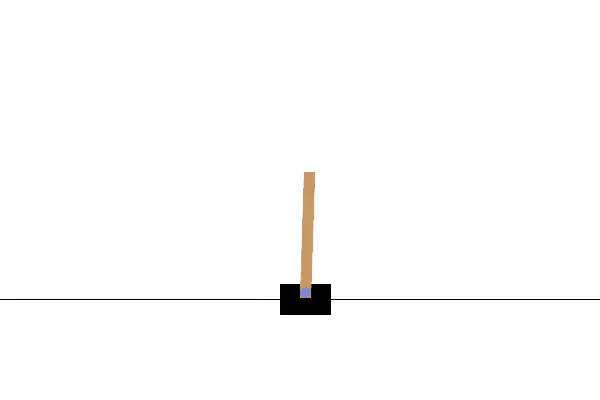

In [8]:
gym_simulation("CartPole-v1", agent)

## Improvements

### Use Future Rewards

First thing to notice is that we are using all rewards at every timestep. But really, we should only
consider future rewards: i.e., the rewards that are actually the consequences of our actions.

$$
g = \sum_t R_t^{future}\nabla_{\theta} log\pi_{\theta}(a_t | s_t)
$$

### Normalize Rewards

Another technique we can use (especially when collecting multiple trajectories, that will come later
on!) is to normalize the rewards: which roughly picks half actions to encourage / discourage, and
keeps the gradient updates moderate.

$$
R_k \leftarrow \frac{R_k - \mu}{\sigma}
$$

### Baseline Subtraction

The idea is to subtract to the reward a _baseline_ $b$, for example the average reward along all
trajectories (What if every trajectory has _always_ positive returns?). In this case, things that
are above average will push their probabilities to happen up while things below average will be
penalized.

$$
\theta_{k+1} = \theta_k - \alpha \sum_{t=0} \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) [R(\tau) - b]
$$

We can do this because on expectation this extra subtracted term will have zero effect, but overall
we'll get reduced variance (proof left as exercise and/or you can find it in the resources).

#### Advantage Function

This value that we multiply with the log-probability to "reinforce" or "depress" the corresponding
actions is called the _advantage function_ and plays a critical role in state-of-the-art algorithms:

$$
A(*) = R(\tau) - b
$$

It measures how better the selected action does compared to the _average_ in the state.

In [9]:
def REINFORCE_v2(env, agent, max_episodes=10_000, max_t=1_000, gamma=1.0):
    scores = []
    for i_episode in range(1, max_episodes + 1):
        rewards = []
        log_probs = []
        state, _ = env.reset()

        for _ in range(max_t):
            action, log_prob = agent.sample_action(state)
            log_probs.append(log_prob)
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            if terminated or truncated:
                break

        discounts = np.power(gamma, np.arange(len(rewards)))
        discounted_rewards = discounts * rewards
        future_returns = discounted_rewards[::-1].cumsum()[::-1]

        baseline = np.mean(future_returns)
        future_returns = future_returns - baseline

        returns_mean = np.mean(future_returns)
        returns_std = np.std(future_returns) + 1.0e-10 # To avoid a zero division
        normalized_returns = (future_returns - returns_mean) / returns_std

        # copy() for negative strides :(
        #   https://discuss.pytorch.org/t/negative-strides-in-tensor-error/134287/2
        agent.learn(log_probs, normalized_returns.copy())

        # Track scores and print statistics
        scores.append(sum(rewards))
        avg_score = np.mean(scores[-100:])
        if i_episode % 100 == 0:
            print(f'Episode {i_episode}\tAverage Score: {avg_score:.2f}')
        if avg_score >= 490.0: # Solved
            print(f'Environment solved at episode {i_episode}\tAverage Score: {avg_score:.2f}')
            break

    return scores

Episode 100	Average Score: 78.11
Episode 200	Average Score: 379.94
Episode 300	Average Score: 398.59
Environment solved at episode 369	Average Score: 490.21


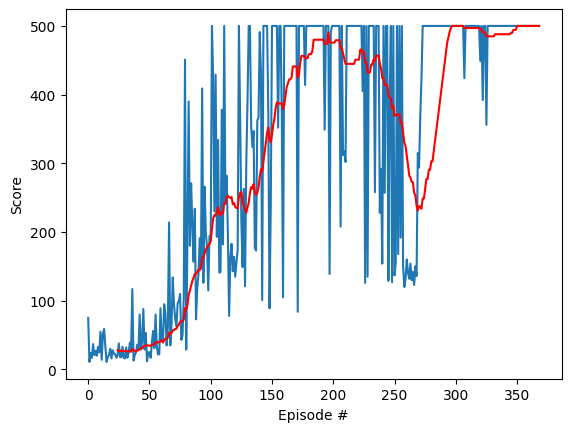

In [10]:
with init_random(gym.make('CartPole-v1')) as env:
    agent_v2 = Agent()
    scores_v2 = REINFORCE_v2(env, agent_v2)
plot_scores(scores_v2)

Moviepy - Building video /tmp/rl-video-episode-0.mp4.
Moviepy - Writing video /tmp/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /tmp/rl-video-episode-0.mp4
MoviePy - Building file /tmp/rl-video.gif with imageio.


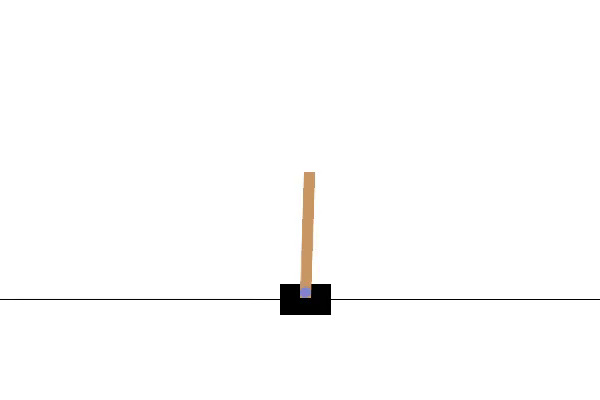

In [11]:
gym_simulation("CartPole-v1", agent_v2)

## What Can We Do Better?

There are other improvements that can be applied:

* To _reduce noise_ on the gradient, we can simply sample multiple different trajectories and learn
  from all of those. Vectorized environments will help with this!
* Actor-critic setup and advanced advantage estimation such as _GAE_ will improve learning.
* We are currently _discarding experiences_ after every learning step. That is because the policy
  effectively changes. But we'll see that with importance sampling we can iterate on the same data
  multiple times and learn in mini-batches!
* Techniques such as "trust region" and "_loss clipping_" will help against degeneration and keep
  the policy learning along smooth gradient directions.

Once we put all of these in place... we'll have PPO!

## Appendix

### Meaning of Loss

Note that the loss function used in policy gradient methods doesn't have the same meaning of the
typical supervised learning setup. In particular, after that first step of gradient descent, there
is no more connection to performance - which is determined by the average return.

The loss function is only useful when evaluated at the current parameters to perform one step of
gradient ascent. After that it loses its meaning and it's value shouldn't be used as a metric for
performance.

More details on [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#id14).
